### process the JMA grib files downloaded for the period 2015 to 2019-11 (i.e. after the _official_ hindcast period)

In [40]:
%matplotlib inline
from matplotlib import pyplot as plt

In [41]:
import pathlib

In [42]:
import numpy as np
import pandas as pd 
import xarray as xr
import pygrib 

In [43]:
from datetime import datetime, timedelta
from dateutil import relativedelta

In [44]:
HOME = pathlib.Path.home()

In [45]:
dict_vars = {}
dict_vars['surf_Prr'] = 'PRECIP'
dict_vars['surf_Pss'] = 'SST'
dict_vars['h2_Ptt'] = 'T2M'
dict_vars['p500_Phh'] = 'Z500'

In [46]:
print(HOME)

/home/nicolasf


In [47]:
dpath = HOME / 'research' / 'Smart_Ideas' / 'data' / 'GCMs' / 'GRIB' / 'JMA'

In [48]:
list_directories = [x for x in dpath.iterdir() if x.is_dir()]

In [49]:
list_directories

[PosixPath('/home/nicolasf/research/Smart_Ideas/data/GCMs/GRIB/JMA/PRECIP'),
 PosixPath('/home/nicolasf/research/Smart_Ideas/data/GCMs/GRIB/JMA/Z500'),
 PosixPath('/home/nicolasf/research/Smart_Ideas/data/GCMs/GRIB/JMA/T2M'),
 PosixPath('/home/nicolasf/research/Smart_Ideas/data/GCMs/GRIB/JMA/SST')]

In [50]:
folder = list_directories[0]

In [51]:
folder

PosixPath('/home/nicolasf/research/Smart_Ideas/data/GCMs/GRIB/JMA/PRECIP')

In [52]:
list_files = list(folder.glob("*"))

In [53]:
list_files.sort()

In [54]:
grb_file_name = list_files[-1]

In [55]:
grb_file_name

PosixPath('/home/nicolasf/research/Smart_Ideas/data/GCMs/GRIB/JMA/PRECIP/surf_Prr_em.201911')

### latest forecast, issued November 2019

### try open using xarray + cfgrib 

In [18]:
# dset_grb = xr.open_dataset(grb_file_name, engine='cfgrib', backend_kwargs={'indexpath':''})

### only one field is returned, seems to correspond to step 4 only ?

valid_time is 2020-03-01

In [20]:
# dset_grb.valid_time

<xarray.DataArray 'valid_time' ()>
array('2020-03-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time        datetime64[ns] ...
    step        timedelta64[ns] ...
    surface     int64 ...
    valid_time  datetime64[ns] 2020-03-01
Attributes:
    standard_name:  time
    long_name:      time

### open with pygrib 

In [56]:
grbs = pygrib.open(str(grb_file_name))

In [57]:
grbs.name

'/home/nicolasf/research/Smart_Ideas/data/GCMs/GRIB/JMA/PRECIP/surf_Prr_em.201911'

In [58]:
var_name_grb = "_".join(grb_file_name.name.split('_')[0:2])

In [59]:
# var_name_grb = "_".join(grb_file_name.split('_')[0:2])[2:]

In [60]:
var_name_grb

'surf_Prr'

In [61]:
dict_vars[var_name_grb]

'PRECIP'

In [62]:
analysis_Dates = []
# valid_Dates = [] valid_Date does not seem to be an attribute included in the grib file (even though it is listed as a key)
validity_Dates = []
data = []

for g in grbs: 
    print(g.forecastTime)
    data.append(g.values)
    analysis_Dates.append(g.analDate)
    # validDates.append(g.validDate)
    validity_Dates.append(datetime.strptime(str(g.validityDate), "%Y%m%d"))   

data = np.array(data)

1
1
2
3


### the validity dates correspond to: 

1) seasonal average (e.g. DJF)   
2) month 1 (e.g. December)   
3) month 2 (e.g. January)   
4) month 3 (e.g. February)   

In [63]:
validity_Dates

[datetime.datetime(2020, 2, 29, 0, 0),
 datetime.datetime(2019, 12, 31, 0, 0),
 datetime.datetime(2020, 1, 31, 0, 0),
 datetime.datetime(2020, 2, 29, 0, 0)]

In [64]:
data.shape

(4, 73, 144)

In [65]:
data = data[1:,:,:]

In [66]:
validity_Dates = validity_Dates[1:]

In [67]:
validity_Dates

[datetime.datetime(2019, 12, 31, 0, 0),
 datetime.datetime(2020, 1, 31, 0, 0),
 datetime.datetime(2020, 2, 29, 0, 0)]

In [68]:
data.shape

(3, 73, 144)

### add new axis, and try and create a xarray dataset from a dict 

In [69]:
data = data[np.newaxis, ...]

In [70]:
data.shape

(1, 3, 73, 144)

In [71]:
lats, lons = g.latlons()

In [72]:
lats = lats[:,0]
lons = lons[0,:]

In [73]:
np.unique(analysis_Dates)[0]

datetime.datetime(2019, 11, 1, 0, 0)

In [74]:
d = {}

d['time'] = (('time'), np.unique(analysis_Dates))
d['step'] = (('step'), [1,2,3])
d['lat'] = (('lat'), lats)
d['lon'] = (('lon'), lons)
d[dict_vars[var_name_grb]] = (('time', 'step', 'lat','lon'), data)

In [75]:
dset = xr.Dataset(d)

In [76]:
dset = dset.sortby('lat')

In [77]:
dset

<xarray.Dataset>
Dimensions:  (lat: 73, lon: 144, step: 3, time: 1)
Coordinates:
  * time     (time) datetime64[ns] 2019-11-01
  * step     (step) int64 1 2 3
  * lat      (lat) float64 -90.0 -87.5 -85.0 -82.5 -80.0 ... 82.5 85.0 87.5 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Data variables:
    PRECIP   (time, step, lat, lon) float64 0.1046 0.1046 0.1046 ... 0.463 0.463

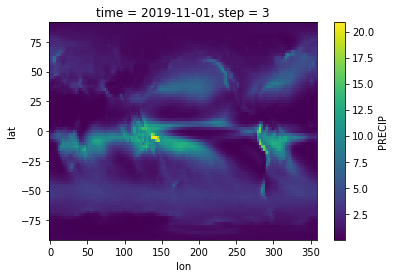

In [79]:
dset['PRECIP'][0,2,:,:].plot()

In [ ]:
validityDates